# 畳み込み変分オートエンコーダ(CVAE)による異常音検知

In [1]:
import numpy as np
import pandas as pd
import librosa as lb
import os
import re
import pathlib
import h5py
import joblib
import shutil
import matplotlib.pyplot as plt
import glob
import wave
import tensorflow as tf

from audio_processing.librosa_compute_spectrogram import wav_to_spectrogram
from utils.data_loader import return_dataset_loader
from train import Train_Pipeline
from test import test
from utils import visualization
from utils import validate

In [2]:
# モジュールのオートリロード用のコマンド
%load_ext autoreload
%autoreload 2

# MLflowのexperimentとRunを設定
ログが置かれたディレクトリを指定して以下のコマンドを実行(mlflowの環境下で実行)

mlflow ui --backend-store-uri /path/to/uri --port 5000

In [3]:
import mlflow
from pathlib import Path

# 各種パスを指定
TRACKING_URI = Path('./mlruns').resolve()

EXPERIMENT_NAME ="CVAE"

# トラッキングサーバ（バックエンド）の場所を指定
mlflow.set_tracking_uri(TRACKING_URI)

# Experimentの生成
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if experiment is None:  # 当該Experiment存在しないとき、新たに作成
    experiment_id = mlflow.create_experiment(
        name=EXPERIMENT_NAME
    )
else: # 当該Experiment存在するとき、IDを取得
    experiment_id = experiment.experiment_id


# Runを設定
RUN_NAME = 'CVAE'
TAGS={
    'version':'1',
}
description='Anomaly detection by CVAE'

# RUNを実行
with mlflow.start_run(experiment_id=experiment_id, run_name=RUN_NAME, tags=TAGS, description=description) as run:
    MLFLOW_RUN_ID = run.info.run_id
    
print("Experiment ID:", experiment_id)
print("Run ID:", MLFLOW_RUN_ID)
print("============================")

# ライフサイクルがdeletedになっているrunを削除（ストレージにrunが蓄積してしまうため）
relative_path = TRACKING_URI.relative_to(Path.cwd())
! mlflow gc --backend-store-uri $relative_path

Experiment ID: 1
Run ID: d9b28e0bc699482d8f01cf93dbb52ada


## Tensor BoardのSummaryWriterを定義
tensorboard --logdir path/to/log_dir

In [4]:
import datetime

# Tensor Board
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = f'TBruns/{current_time}/MLFLOW_RUN_ID_{MLFLOW_RUN_ID}'
SUMMARY_WRITER = tf.summary.create_file_writer(log_dir)

In [5]:
# %load_ext tensorboard
# %tensorboard --logdir logs

訓練データのパスを定義

In [6]:
'''
testdata : '210921_0032.wav' # 最終的な性能を評価するためのデータ
valdata : '210922_0033.wav' # 閾値などを検討する際に使用するデータ
'''
datas_dir = pathlib.Path('../../data/16000hz騒音データとスタートを合わせた音データ')
label_data_dir = pathlib.Path('../../data/学習データ(オリジナル)/')

all_traindata = [datas_dir/'210919_0031.wav']

print(all_traindata)

[WindowsPath('../../data/16000hz騒音データとスタートを合わせた音データ/210919_0031.wav')]


各要素をラベルのDFとするリストを定義

In [7]:
label_data_dir = pathlib.Path('../../data/学習データ(オリジナル)/')
# label_data_dir = pathlib.Path('../../data/プログラム確認用音声データ/label')

# ラベルのDFを作成
list_df_labelData =[]
for i in all_traindata:
#     label_data_name = i.split('/')[-1].replace('.wav', '.csv') 
    labelData_name = i.with_suffix('.csv').name
    labelData_file = label_data_dir/labelData_name
    df_labelData=pd.read_csv(labelData_file, skiprows=4, usecols=[1], header=None) 
    list_df_labelData.append(df_labelData)

# display(list_df_labelData[0])

パラメータ

In [8]:
# スペクトログラムのパラメータ
SR = 16000 # サンプリング周波数
DURATION = 1 # スペクトログラムの時間幅[s]
# SPEC_PARAMS = {'frame_length':2048, 'frame_step':400} # スペクトログラムのパラメータ
MEL_PAEAMS = {'sr':SR, 'n_fft':2048, 'hop_length':512, 'n_mels':128, 'fmax':SR/2, 'fmin':80} # メル尺度のパラメータ
# npy関係のファイルを出力するフォルダ
NPY_OUTPUT = '../autoencoder-anomaly-detection/data_output/npy/train'

IMAGE_SIZE = [128, 32] # resizeする際のサイズ
VAL_RATE = 0.1  # 全データに対するバリデーションデータの割合
BATCH_SIZE = 512 # バッチサイズ
EPOCHS = 150  # エポック数
LATENT_DIM = 500 # 潜在空間の次元数
R_LOSS_FACTOR=1000 # 損失関数における再構成誤差項をKL_lossの何倍にするか

適用するデータ拡張を指定 

In [9]:
TRANSFORM_NAME = [
    'GaussianNoiseSNR',
    'PinkNoiseSNR',
    'PitchShift',
    'TimeShift',
    'VolumeShift',
]

In [10]:
####### mlflow ##########
with mlflow.start_run(run_id=MLFLOW_RUN_ID):
    mlflow.log_params(
        {
            "SR":SR,
            "DURATION":DURATION,
            "MEL_PAEAMS":MEL_PAEAMS,
            "IMAGE_SIZE":IMAGE_SIZE,
            "BATCH_SIZE":BATCH_SIZE,
            "EPOCHS":EPOCHS,
            "LATENT_DIM": LATENT_DIM,
            "R_LOSS_FACTOR":R_LOSS_FACTOR,
            "TRANSFORM_NAME":TRANSFORM_NAME
        }
    )
#########################

メルスペクトログラムに変換

In [11]:
%%time
train_mean, train_std  = wav_to_spectrogram(NPY_OUTPUT,all_traindata, SR, DURATION, MEL_PAEAMS, TRANSFORM_NAME, list_df_labelData, 
                                            overwrite=False)

npy_output: ..\autoencoder-anomaly-detection\data_output\npy\train\npy_files
..\autoencoder-anomaly-detection\data_output\npy\trainが既に存在します
上書せずに終了
Wall time: 3 ms


標準化のための平均値と標準偏差を訓練データから算出。テストデータの標準化にも使用

In [12]:
print(f'平均値：{train_mean}')
print(f'標準偏差：{train_std}')

平均値：-41.470706939697266
標準偏差：10.922344207763672


データセットの定義

In [13]:
# 訓練データを訓練データとバリデーションデータに分割
list_train_npyFiles = glob.glob(f'{NPY_OUTPUT}/npy_files/*')

# list_train_npyFiles = list_train_npyFiles[:10000]


num_all_data = len(list_train_npyFiles)
print('全データ数:', num_all_data)

index_array = np.array(range(num_all_data))
np.random.shuffle(index_array)
num_train_data = int(num_all_data*(1-VAL_RATE))
idx_train_data = index_array[:num_train_data]
idx_val_data = index_array[num_train_data:]
print('全データ×(1-VAL_RATE):', num_train_data)

train_npyFiles = [list_train_npyFiles[idx] for idx in idx_train_data]
val_npyFiles = [list_train_npyFiles[idx] for idx in idx_val_data]
print('訓練データ数：',len(train_npyFiles))
print('valデータ数：',len(val_npyFiles)) 

# データセット
train_dataset = return_dataset_loader(train_npyFiles,
                                      IMAGE_SIZE,
                                      mean=train_mean, 
                                      std=train_std, 
                                      training=True, 
                                      batch_size=BATCH_SIZE)
val_dataset = return_dataset_loader(val_npyFiles, 
                                    IMAGE_SIZE,
                                    mean=train_mean, 
                                    std=train_std, 
                                    training=True, 
                                    batch_size=BATCH_SIZE)

全データ数: 170818
全データ×(1-VAL_RATE): 153736
訓練データ数： 153736
valデータ数： 17082


In [14]:
####### mlflow ##########
with mlflow.start_run(run_id=MLFLOW_RUN_ID):
    mlflow.log_params(
        {
            "train_mean":train_mean,
            "train_std":train_std,
            "Number of train data":num_all_data
        }
    )
#########################

# 訓練

In [15]:
# 実行時のスクリプトを保存
####### mlflow ##########
with mlflow.start_run(run_id=MLFLOW_RUN_ID):
    mlflow.log_artifact("Anomalydetection.ipynb", artifact_path="source_code")
    mlflow.log_artifact("./model/CVAE.py", artifact_path="source_code/model")
########################

In [16]:
# モデルの定義
from model.CVAE import ConvolutionalVariationalAutoEncoder

In [17]:
def get_model(latent_dim):
    # 使用するCVAEの定義
    model = ConvolutionalVariationalAutoEncoder(
        encoder_conv_filters = [32,64,64, 64],
        encoder_conv_kernel_size = [3,3,3,3],
        encoder_conv_strides = [1,2,2,1],
        decoder_conv_t_filters = [64,64,32,3],
        decoder_conv_t_kernel_size = [3,3,3,3],
        decoder_conv_t_strides = [1,2,2,1],
        latent_dim = latent_dim,
        use_batch_norm = True,
        use_dropout = True
    )
    
    # optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)    
    
    return model, optimizer

In [18]:
CVAE, optimizer = get_model(LATENT_DIM)    
model = CVAE.get_functionalModel(input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3))
model.summary()

# checkpoint
dir_checkpoint = f'./data_output/tf_ckpts/{MLFLOW_RUN_ID}'
step_epoch=tf.Variable(1)
ckpt = tf.train.Checkpoint(step=step_epoch, OPTIMIZER=optimizer, MODEL=CVAE)
manager = tf.train.CheckpointManager(ckpt, dir_checkpoint, max_to_keep=2) # サイズが大きいのでなるべく少なく

Model: "functionalModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_in (InputLayer)        [(None, 128, 32, 3)]      0         
_________________________________________________________________
encoder (Encoder)            ((None, 500), (None, 500) 16479144  
_________________________________________________________________
decoder (Decoder)            (None, 128, 32, 3)        24781355  
Total params: 24,781,355
Trainable params: 24,780,587
Non-trainable params: 768
_________________________________________________________________


In [19]:
TP = Train_Pipeline(SUMMARY_WRITER)
history = TP.train(CVAE, optimizer, R_LOSS_FACTOR, EPOCHS, train_dataset, val_dataset, ckpt, manager)

Epoch[1/150]: 100%|███████████████████| 301/301 [02:04<00:00,  2.42batch/s, total_loss=13.5, reconstructed_loss=0.0122]


0/150  Epoch total_loss: 13.494  reconstructed_loss: 0.012 val_reconstructed_loss: 0.012
Saved checkpoint for step 2: ./data_output/tf_ckpts/d9b28e0bc699482d8f01cf93dbb52ada\ckpt-1


Epoch[2/150]: 100%|██████████████████| 301/301 [00:34<00:00,  8.60batch/s, total_loss=5.13, reconstructed_loss=0.00432]


1/150  Epoch total_loss: 5.135  reconstructed_loss: 0.004 val_reconstructed_loss: 0.003
Saved checkpoint for step 3: ./data_output/tf_ckpts/d9b28e0bc699482d8f01cf93dbb52ada\ckpt-2


Epoch[3/150]: 100%|███████████████████| 301/301 [00:34<00:00,  8.65batch/s, total_loss=4.4, reconstructed_loss=0.00368]


2/150  Epoch total_loss: 4.400  reconstructed_loss: 0.004 val_reconstructed_loss: 0.004


Epoch[4/150]: 100%|██████████████████| 301/301 [00:34<00:00,  8.61batch/s, total_loss=4.04, reconstructed_loss=0.00338]


3/150  Epoch total_loss: 4.042  reconstructed_loss: 0.003 val_reconstructed_loss: 0.002
Saved checkpoint for step 5: ./data_output/tf_ckpts/d9b28e0bc699482d8f01cf93dbb52ada\ckpt-3


Epoch[5/150]: 100%|██████████████████| 301/301 [00:35<00:00,  8.60batch/s, total_loss=3.75, reconstructed_loss=0.00315]


4/150  Epoch total_loss: 3.752  reconstructed_loss: 0.003 val_reconstructed_loss: 0.002
Saved checkpoint for step 6: ./data_output/tf_ckpts/d9b28e0bc699482d8f01cf93dbb52ada\ckpt-4


Epoch[6/150]: 100%|██████████████████| 301/301 [00:34<00:00,  8.62batch/s, total_loss=3.58, reconstructed_loss=0.00302]


5/150  Epoch total_loss: 3.578  reconstructed_loss: 0.003 val_reconstructed_loss: 0.003


Epoch[7/150]: 100%|████████████████████| 301/301 [00:35<00:00,  8.58batch/s, total_loss=3.59, reconstructed_loss=0.003]


6/150  Epoch total_loss: 3.585  reconstructed_loss: 0.003 val_reconstructed_loss: 0.002
Saved checkpoint for step 8: ./data_output/tf_ckpts/d9b28e0bc699482d8f01cf93dbb52ada\ckpt-5


Epoch[8/150]: 100%|██████████████████| 301/301 [00:34<00:00,  8.62batch/s, total_loss=3.38, reconstructed_loss=0.00285]


7/150  Epoch total_loss: 3.376  reconstructed_loss: 0.003 val_reconstructed_loss: 0.002
Saved checkpoint for step 9: ./data_output/tf_ckpts/d9b28e0bc699482d8f01cf93dbb52ada\ckpt-6


Epoch[9/150]: 100%|██████████████████| 301/301 [00:35<00:00,  8.57batch/s, total_loss=3.22, reconstructed_loss=0.00274]


8/150  Epoch total_loss: 3.218  reconstructed_loss: 0.003 val_reconstructed_loss: 0.004


Epoch[10/150]: 100%|█████████████████| 301/301 [00:34<00:00,  8.62batch/s, total_loss=3.42, reconstructed_loss=0.00281]


9/150  Epoch total_loss: 3.416  reconstructed_loss: 0.003 val_reconstructed_loss: 0.002
Saved checkpoint for step 11: ./data_output/tf_ckpts/d9b28e0bc699482d8f01cf93dbb52ada\ckpt-7


Epoch[11/150]: 100%|█████████████████| 301/301 [00:35<00:00,  8.60batch/s, total_loss=3.01, reconstructed_loss=0.00259]


10/150  Epoch total_loss: 3.012  reconstructed_loss: 0.003 val_reconstructed_loss: 0.002
Saved checkpoint for step 12: ./data_output/tf_ckpts/d9b28e0bc699482d8f01cf93dbb52ada\ckpt-8


Epoch[12/150]: 100%|█████████████████| 301/301 [00:34<00:00,  8.62batch/s, total_loss=2.95, reconstructed_loss=0.00254]


11/150  Epoch total_loss: 2.951  reconstructed_loss: 0.003 val_reconstructed_loss: 0.004


Epoch[13/150]: 100%|█████████████████| 301/301 [00:35<00:00,  8.55batch/s, total_loss=2.99, reconstructed_loss=0.00256]


12/150  Epoch total_loss: 2.989  reconstructed_loss: 0.003 val_reconstructed_loss: 0.002
Saved checkpoint for step 14: ./data_output/tf_ckpts/d9b28e0bc699482d8f01cf93dbb52ada\ckpt-9


Epoch[14/150]: 100%|█████████████████| 301/301 [00:35<00:00,  8.59batch/s, total_loss=2.88, reconstructed_loss=0.00249]


13/150  Epoch total_loss: 2.876  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002
Saved checkpoint for step 15: ./data_output/tf_ckpts/d9b28e0bc699482d8f01cf93dbb52ada\ckpt-10


Epoch[15/150]: 100%|█████████████████| 301/301 [00:34<00:00,  8.61batch/s, total_loss=2.84, reconstructed_loss=0.00246]


14/150  Epoch total_loss: 2.842  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002
Saved checkpoint for step 16: ./data_output/tf_ckpts/d9b28e0bc699482d8f01cf93dbb52ada\ckpt-11


Epoch[16/150]: 100%|█████████████████| 301/301 [00:34<00:00,  8.61batch/s, total_loss=2.73, reconstructed_loss=0.00238]


15/150  Epoch total_loss: 2.734  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[17/150]: 100%|██████████████████| 301/301 [00:35<00:00,  8.59batch/s, total_loss=2.7, reconstructed_loss=0.00236]


16/150  Epoch total_loss: 2.698  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002
Saved checkpoint for step 18: ./data_output/tf_ckpts/d9b28e0bc699482d8f01cf93dbb52ada\ckpt-12


Epoch[18/150]: 100%|█████████████████| 301/301 [00:34<00:00,  8.62batch/s, total_loss=2.71, reconstructed_loss=0.00236]


17/150  Epoch total_loss: 2.713  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[19/150]: 100%|██████████████████| 301/301 [00:34<00:00,  8.61batch/s, total_loss=2.63, reconstructed_loss=0.0023]


18/150  Epoch total_loss: 2.627  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002
Saved checkpoint for step 20: ./data_output/tf_ckpts/d9b28e0bc699482d8f01cf93dbb52ada\ckpt-13


Epoch[20/150]: 100%|█████████████████| 301/301 [00:35<00:00,  8.54batch/s, total_loss=2.57, reconstructed_loss=0.00226]


19/150  Epoch total_loss: 2.566  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[21/150]: 100%|█████████████████| 301/301 [00:34<00:00,  8.60batch/s, total_loss=2.55, reconstructed_loss=0.00225]


20/150  Epoch total_loss: 2.550  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002
Saved checkpoint for step 22: ./data_output/tf_ckpts/d9b28e0bc699482d8f01cf93dbb52ada\ckpt-14


Epoch[22/150]: 100%|██████████████████| 301/301 [00:35<00:00,  8.58batch/s, total_loss=2.5, reconstructed_loss=0.00221]


21/150  Epoch total_loss: 2.504  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[23/150]: 100%|█████████████████| 301/301 [00:35<00:00,  8.59batch/s, total_loss=2.49, reconstructed_loss=0.00221]


22/150  Epoch total_loss: 2.494  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[24/150]: 100%|█████████████████| 301/301 [00:34<00:00,  8.61batch/s, total_loss=2.46, reconstructed_loss=0.00218]


23/150  Epoch total_loss: 2.455  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002
Saved checkpoint for step 25: ./data_output/tf_ckpts/d9b28e0bc699482d8f01cf93dbb52ada\ckpt-15


Epoch[25/150]: 100%|█████████████████| 301/301 [00:35<00:00,  8.58batch/s, total_loss=2.44, reconstructed_loss=0.00217]


24/150  Epoch total_loss: 2.441  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002
Saved checkpoint for step 26: ./data_output/tf_ckpts/d9b28e0bc699482d8f01cf93dbb52ada\ckpt-16


Epoch[26/150]: 100%|█████████████████| 301/301 [00:35<00:00,  8.58batch/s, total_loss=2.43, reconstructed_loss=0.00216]


25/150  Epoch total_loss: 2.427  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[27/150]: 100%|██████████████████| 301/301 [00:35<00:00,  8.57batch/s, total_loss=2.4, reconstructed_loss=0.00214]


26/150  Epoch total_loss: 2.401  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002
Saved checkpoint for step 28: ./data_output/tf_ckpts/d9b28e0bc699482d8f01cf93dbb52ada\ckpt-17


Epoch[28/150]: 100%|█████████████████| 301/301 [00:35<00:00,  8.59batch/s, total_loss=2.36, reconstructed_loss=0.00211]


27/150  Epoch total_loss: 2.359  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[29/150]: 100%|██████████████████| 301/301 [00:35<00:00,  8.53batch/s, total_loss=2.35, reconstructed_loss=0.0021]


28/150  Epoch total_loss: 2.350  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002
Saved checkpoint for step 30: ./data_output/tf_ckpts/d9b28e0bc699482d8f01cf93dbb52ada\ckpt-18


Epoch[30/150]: 100%|█████████████████| 301/301 [00:34<00:00,  8.61batch/s, total_loss=2.36, reconstructed_loss=0.00211]


29/150  Epoch total_loss: 2.362  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[31/150]: 100%|█████████████████| 301/301 [00:34<00:00,  8.61batch/s, total_loss=2.32, reconstructed_loss=0.00207]


30/150  Epoch total_loss: 2.320  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002
Saved checkpoint for step 32: ./data_output/tf_ckpts/d9b28e0bc699482d8f01cf93dbb52ada\ckpt-19


Epoch[32/150]: 100%|█████████████████| 301/301 [00:35<00:00,  8.59batch/s, total_loss=2.32, reconstructed_loss=0.00208]


31/150  Epoch total_loss: 2.323  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[33/150]: 100%|██████████████████| 301/301 [00:35<00:00,  8.59batch/s, total_loss=2.3, reconstructed_loss=0.00206]


32/150  Epoch total_loss: 2.297  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[34/150]: 100%|█████████████████| 301/301 [00:34<00:00,  8.62batch/s, total_loss=2.27, reconstructed_loss=0.00204]


33/150  Epoch total_loss: 2.274  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002
Saved checkpoint for step 35: ./data_output/tf_ckpts/d9b28e0bc699482d8f01cf93dbb52ada\ckpt-20


Epoch[35/150]: 100%|█████████████████| 301/301 [00:35<00:00,  8.60batch/s, total_loss=2.26, reconstructed_loss=0.00203]


34/150  Epoch total_loss: 2.261  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[36/150]: 100%|█████████████████| 301/301 [00:34<00:00,  8.64batch/s, total_loss=2.25, reconstructed_loss=0.00202]


35/150  Epoch total_loss: 2.245  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[37/150]: 100%|███████████████████| 301/301 [00:34<00:00,  8.63batch/s, total_loss=2.23, reconstructed_loss=0.002]


36/150  Epoch total_loss: 2.234  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[38/150]: 100%|███████████████████| 301/301 [00:34<00:00,  8.62batch/s, total_loss=2.23, reconstructed_loss=0.002]


37/150  Epoch total_loss: 2.232  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[39/150]: 100%|█████████████████| 301/301 [00:34<00:00,  8.64batch/s, total_loss=2.22, reconstructed_loss=0.00199]


38/150  Epoch total_loss: 2.219  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[40/150]: 100%|██████████████████| 301/301 [00:35<00:00,  8.55batch/s, total_loss=2.2, reconstructed_loss=0.00198]


39/150  Epoch total_loss: 2.202  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002
Saved checkpoint for step 41: ./data_output/tf_ckpts/d9b28e0bc699482d8f01cf93dbb52ada\ckpt-21


Epoch[41/150]: 100%|█████████████████| 301/301 [00:35<00:00,  8.59batch/s, total_loss=2.22, reconstructed_loss=0.00199]


40/150  Epoch total_loss: 2.217  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[42/150]: 100%|█████████████████| 301/301 [00:34<00:00,  8.61batch/s, total_loss=2.19, reconstructed_loss=0.00197]


41/150  Epoch total_loss: 2.193  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[43/150]: 100%|█████████████████| 301/301 [00:34<00:00,  8.62batch/s, total_loss=2.18, reconstructed_loss=0.00196]


42/150  Epoch total_loss: 2.179  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002
Saved checkpoint for step 44: ./data_output/tf_ckpts/d9b28e0bc699482d8f01cf93dbb52ada\ckpt-22


Epoch[44/150]: 100%|█████████████████| 301/301 [00:34<00:00,  8.63batch/s, total_loss=2.17, reconstructed_loss=0.00195]


43/150  Epoch total_loss: 2.169  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002
Saved checkpoint for step 45: ./data_output/tf_ckpts/d9b28e0bc699482d8f01cf93dbb52ada\ckpt-23


Epoch[45/150]: 100%|█████████████████| 301/301 [00:34<00:00,  8.62batch/s, total_loss=2.17, reconstructed_loss=0.00195]


44/150  Epoch total_loss: 2.167  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[46/150]: 100%|█████████████████| 301/301 [00:34<00:00,  8.63batch/s, total_loss=2.17, reconstructed_loss=0.00194]


45/150  Epoch total_loss: 2.166  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[47/150]: 100%|█████████████████| 301/301 [00:34<00:00,  8.62batch/s, total_loss=2.15, reconstructed_loss=0.00193]


46/150  Epoch total_loss: 2.151  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002
Saved checkpoint for step 48: ./data_output/tf_ckpts/d9b28e0bc699482d8f01cf93dbb52ada\ckpt-24


Epoch[48/150]: 100%|█████████████████| 301/301 [00:34<00:00,  8.62batch/s, total_loss=2.14, reconstructed_loss=0.00192]


47/150  Epoch total_loss: 2.140  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[49/150]: 100%|█████████████████| 301/301 [00:34<00:00,  8.61batch/s, total_loss=2.14, reconstructed_loss=0.00192]


48/150  Epoch total_loss: 2.138  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002
Saved checkpoint for step 50: ./data_output/tf_ckpts/d9b28e0bc699482d8f01cf93dbb52ada\ckpt-25


Epoch[50/150]: 100%|█████████████████| 301/301 [00:34<00:00,  8.63batch/s, total_loss=2.14, reconstructed_loss=0.00192]


49/150  Epoch total_loss: 2.138  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[51/150]: 100%|█████████████████| 301/301 [00:34<00:00,  8.63batch/s, total_loss=2.13, reconstructed_loss=0.00191]


50/150  Epoch total_loss: 2.126  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002
Saved checkpoint for step 52: ./data_output/tf_ckpts/d9b28e0bc699482d8f01cf93dbb52ada\ckpt-26


Epoch[52/150]: 100%|██████████████████| 301/301 [00:34<00:00,  8.61batch/s, total_loss=2.12, reconstructed_loss=0.0019]


51/150  Epoch total_loss: 2.116  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[53/150]: 100%|██████████████████| 301/301 [00:34<00:00,  8.62batch/s, total_loss=2.12, reconstructed_loss=0.0019]


52/150  Epoch total_loss: 2.121  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[54/150]: 100%|█████████████████| 301/301 [00:34<00:00,  8.63batch/s, total_loss=2.11, reconstructed_loss=0.00189]


53/150  Epoch total_loss: 2.108  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002
Saved checkpoint for step 55: ./data_output/tf_ckpts/d9b28e0bc699482d8f01cf93dbb52ada\ckpt-27


Epoch[55/150]: 100%|█████████████████| 301/301 [00:34<00:00,  8.62batch/s, total_loss=2.11, reconstructed_loss=0.00189]


54/150  Epoch total_loss: 2.105  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[56/150]: 100%|██████████████████| 301/301 [00:34<00:00,  8.62batch/s, total_loss=2.1, reconstructed_loss=0.00188]


55/150  Epoch total_loss: 2.100  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[57/150]: 100%|█████████████████| 301/301 [00:34<00:00,  8.62batch/s, total_loss=2.09, reconstructed_loss=0.00188]


56/150  Epoch total_loss: 2.094  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[58/150]: 100%|█████████████████| 301/301 [00:34<00:00,  8.64batch/s, total_loss=2.09, reconstructed_loss=0.00187]


57/150  Epoch total_loss: 2.093  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[59/150]: 100%|█████████████████| 301/301 [00:34<00:00,  8.61batch/s, total_loss=2.09, reconstructed_loss=0.00187]


58/150  Epoch total_loss: 2.091  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[60/150]: 100%|█████████████████| 301/301 [00:35<00:00,  8.59batch/s, total_loss=2.08, reconstructed_loss=0.00186]


59/150  Epoch total_loss: 2.077  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[61/150]: 100%|█████████████████| 301/301 [00:34<00:00,  8.63batch/s, total_loss=2.08, reconstructed_loss=0.00186]


60/150  Epoch total_loss: 2.077  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[62/150]: 100%|█████████████████| 301/301 [00:34<00:00,  8.61batch/s, total_loss=2.08, reconstructed_loss=0.00186]


61/150  Epoch total_loss: 2.077  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002
Saved checkpoint for step 63: ./data_output/tf_ckpts/d9b28e0bc699482d8f01cf93dbb52ada\ckpt-28


Epoch[63/150]: 100%|█████████████████| 301/301 [00:34<00:00,  8.61batch/s, total_loss=2.07, reconstructed_loss=0.00185]


62/150  Epoch total_loss: 2.071  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[64/150]: 100%|█████████████████| 301/301 [00:34<00:00,  8.61batch/s, total_loss=2.07, reconstructed_loss=0.00185]


63/150  Epoch total_loss: 2.067  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002
Saved checkpoint for step 65: ./data_output/tf_ckpts/d9b28e0bc699482d8f01cf93dbb52ada\ckpt-29


Epoch[65/150]: 100%|█████████████████| 301/301 [00:35<00:00,  8.60batch/s, total_loss=2.06, reconstructed_loss=0.00184]


64/150  Epoch total_loss: 2.060  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[66/150]: 100%|█████████████████| 301/301 [00:34<00:00,  8.63batch/s, total_loss=2.06, reconstructed_loss=0.00184]


65/150  Epoch total_loss: 2.056  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[67/150]: 100%|█████████████████| 301/301 [00:34<00:00,  8.62batch/s, total_loss=2.06, reconstructed_loss=0.00184]


66/150  Epoch total_loss: 2.058  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[68/150]: 100%|█████████████████| 301/301 [00:35<00:00,  8.59batch/s, total_loss=2.05, reconstructed_loss=0.00183]


67/150  Epoch total_loss: 2.052  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[69/150]: 100%|█████████████████| 301/301 [00:34<00:00,  8.62batch/s, total_loss=2.05, reconstructed_loss=0.00183]


68/150  Epoch total_loss: 2.046  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[70/150]: 100%|█████████████████| 301/301 [00:34<00:00,  8.63batch/s, total_loss=2.05, reconstructed_loss=0.00183]


69/150  Epoch total_loss: 2.046  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[71/150]: 100%|█████████████████| 301/301 [00:35<00:00,  8.59batch/s, total_loss=2.04, reconstructed_loss=0.00182]


70/150  Epoch total_loss: 2.042  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002
Saved checkpoint for step 72: ./data_output/tf_ckpts/d9b28e0bc699482d8f01cf93dbb52ada\ckpt-30


Epoch[72/150]: 100%|█████████████████| 301/301 [00:35<00:00,  8.51batch/s, total_loss=2.04, reconstructed_loss=0.00182]


71/150  Epoch total_loss: 2.042  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002
Saved checkpoint for step 73: ./data_output/tf_ckpts/d9b28e0bc699482d8f01cf93dbb52ada\ckpt-31


Epoch[73/150]: 100%|█████████████████| 301/301 [00:34<00:00,  8.63batch/s, total_loss=2.03, reconstructed_loss=0.00182]


72/150  Epoch total_loss: 2.034  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[74/150]: 100%|█████████████████| 301/301 [00:35<00:00,  8.57batch/s, total_loss=2.03, reconstructed_loss=0.00181]


73/150  Epoch total_loss: 2.030  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[75/150]: 100%|█████████████████| 301/301 [00:34<00:00,  8.63batch/s, total_loss=2.03, reconstructed_loss=0.00182]


74/150  Epoch total_loss: 2.034  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002
Saved checkpoint for step 76: ./data_output/tf_ckpts/d9b28e0bc699482d8f01cf93dbb52ada\ckpt-32


Epoch[76/150]: 100%|█████████████████| 301/301 [00:34<00:00,  8.62batch/s, total_loss=2.03, reconstructed_loss=0.00181]


75/150  Epoch total_loss: 2.028  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[77/150]: 100%|█████████████████| 301/301 [00:34<00:00,  8.62batch/s, total_loss=2.02, reconstructed_loss=0.00181]


76/150  Epoch total_loss: 2.022  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[78/150]: 100%|█████████████████| 301/301 [00:34<00:00,  8.61batch/s, total_loss=2.03, reconstructed_loss=0.00181]


77/150  Epoch total_loss: 2.031  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[79/150]: 100%|██████████████████| 301/301 [00:34<00:00,  8.62batch/s, total_loss=2.02, reconstructed_loss=0.0018]


78/150  Epoch total_loss: 2.017  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[80/150]: 100%|██████████████████| 301/301 [00:34<00:00,  8.64batch/s, total_loss=2.01, reconstructed_loss=0.0018]


79/150  Epoch total_loss: 2.014  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[81/150]: 100%|█████████████████| 301/301 [00:34<00:00,  8.62batch/s, total_loss=2.01, reconstructed_loss=0.00179]


80/150  Epoch total_loss: 2.010  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[82/150]: 100%|█████████████████| 301/301 [00:34<00:00,  8.63batch/s, total_loss=2.01, reconstructed_loss=0.00179]


81/150  Epoch total_loss: 2.007  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[83/150]: 100%|████████████████████| 301/301 [00:34<00:00,  8.64batch/s, total_loss=2, reconstructed_loss=0.00179]


82/150  Epoch total_loss: 2.005  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[84/150]: 100%|████████████████████| 301/301 [00:35<00:00,  8.59batch/s, total_loss=2, reconstructed_loss=0.00179]


83/150  Epoch total_loss: 2.005  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[85/150]: 100%|████████████████████| 301/301 [00:34<00:00,  8.62batch/s, total_loss=2, reconstructed_loss=0.00179]


84/150  Epoch total_loss: 2.004  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002
Saved checkpoint for step 86: ./data_output/tf_ckpts/d9b28e0bc699482d8f01cf93dbb52ada\ckpt-33


Epoch[86/150]: 100%|████████████████████| 301/301 [00:34<00:00,  8.61batch/s, total_loss=2, reconstructed_loss=0.00178]


85/150  Epoch total_loss: 1.997  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[87/150]: 100%|█████████████████| 301/301 [00:34<00:00,  8.60batch/s, total_loss=1.99, reconstructed_loss=0.00177]


86/150  Epoch total_loss: 1.991  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[88/150]: 100%|█████████████████| 301/301 [00:34<00:00,  8.63batch/s, total_loss=1.99, reconstructed_loss=0.00177]


87/150  Epoch total_loss: 1.989  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[89/150]: 100%|█████████████████| 301/301 [00:34<00:00,  8.64batch/s, total_loss=1.99, reconstructed_loss=0.00177]


88/150  Epoch total_loss: 1.987  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002
Saved checkpoint for step 90: ./data_output/tf_ckpts/d9b28e0bc699482d8f01cf93dbb52ada\ckpt-34


Epoch[90/150]: 100%|█████████████████| 301/301 [00:35<00:00,  8.60batch/s, total_loss=1.98, reconstructed_loss=0.00177]


89/150  Epoch total_loss: 1.984  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[91/150]: 100%|█████████████████| 301/301 [00:35<00:00,  8.58batch/s, total_loss=1.98, reconstructed_loss=0.00176]


90/150  Epoch total_loss: 1.980  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[92/150]: 100%|█████████████████| 301/301 [00:34<00:00,  8.63batch/s, total_loss=1.98, reconstructed_loss=0.00176]


91/150  Epoch total_loss: 1.977  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[93/150]: 100%|█████████████████| 301/301 [00:34<00:00,  8.62batch/s, total_loss=1.97, reconstructed_loss=0.00176]


92/150  Epoch total_loss: 1.971  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[94/150]: 100%|█████████████████| 301/301 [00:35<00:00,  8.48batch/s, total_loss=1.97, reconstructed_loss=0.00175]


93/150  Epoch total_loss: 1.967  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[95/150]: 100%|█████████████████| 301/301 [00:34<00:00,  8.63batch/s, total_loss=1.97, reconstructed_loss=0.00175]


94/150  Epoch total_loss: 1.966  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002
Saved checkpoint for step 96: ./data_output/tf_ckpts/d9b28e0bc699482d8f01cf93dbb52ada\ckpt-35


Epoch[96/150]: 100%|█████████████████| 301/301 [00:34<00:00,  8.60batch/s, total_loss=1.96, reconstructed_loss=0.00175]


95/150  Epoch total_loss: 1.962  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002
Saved checkpoint for step 97: ./data_output/tf_ckpts/d9b28e0bc699482d8f01cf93dbb52ada\ckpt-36


Epoch[97/150]: 100%|█████████████████| 301/301 [00:34<00:00,  8.62batch/s, total_loss=1.96, reconstructed_loss=0.00174]


96/150  Epoch total_loss: 1.959  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[98/150]: 100%|█████████████████| 301/301 [00:34<00:00,  8.63batch/s, total_loss=1.96, reconstructed_loss=0.00174]


97/150  Epoch total_loss: 1.957  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[99/150]: 100%|█████████████████| 301/301 [00:34<00:00,  8.62batch/s, total_loss=1.95, reconstructed_loss=0.00174]


98/150  Epoch total_loss: 1.953  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[100/150]: 100%|████████████████| 301/301 [00:34<00:00,  8.64batch/s, total_loss=1.95, reconstructed_loss=0.00174]


99/150  Epoch total_loss: 1.952  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[101/150]: 100%|████████████████| 301/301 [00:34<00:00,  8.63batch/s, total_loss=1.95, reconstructed_loss=0.00173]


100/150  Epoch total_loss: 1.950  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002
Saved checkpoint for step 102: ./data_output/tf_ckpts/d9b28e0bc699482d8f01cf93dbb52ada\ckpt-37


Epoch[102/150]: 100%|████████████████| 301/301 [00:34<00:00,  8.60batch/s, total_loss=1.94, reconstructed_loss=0.00173]


101/150  Epoch total_loss: 1.944  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[103/150]: 100%|████████████████| 301/301 [00:34<00:00,  8.61batch/s, total_loss=1.94, reconstructed_loss=0.00173]


102/150  Epoch total_loss: 1.944  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[104/150]: 100%|████████████████| 301/301 [00:34<00:00,  8.65batch/s, total_loss=1.94, reconstructed_loss=0.00173]


103/150  Epoch total_loss: 1.943  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002
Saved checkpoint for step 105: ./data_output/tf_ckpts/d9b28e0bc699482d8f01cf93dbb52ada\ckpt-38


Epoch[105/150]: 100%|████████████████| 301/301 [00:35<00:00,  8.60batch/s, total_loss=1.94, reconstructed_loss=0.00173]


104/150  Epoch total_loss: 1.941  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[106/150]: 100%|████████████████| 301/301 [00:34<00:00,  8.60batch/s, total_loss=1.94, reconstructed_loss=0.00172]


105/150  Epoch total_loss: 1.939  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[107/150]: 100%|████████████████| 301/301 [00:34<00:00,  8.63batch/s, total_loss=1.94, reconstructed_loss=0.00172]


106/150  Epoch total_loss: 1.936  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[108/150]: 100%|████████████████| 301/301 [00:35<00:00,  8.58batch/s, total_loss=1.93, reconstructed_loss=0.00172]


107/150  Epoch total_loss: 1.935  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002
Saved checkpoint for step 109: ./data_output/tf_ckpts/d9b28e0bc699482d8f01cf93dbb52ada\ckpt-39


Epoch[109/150]: 100%|████████████████| 301/301 [00:34<00:00,  8.63batch/s, total_loss=1.93, reconstructed_loss=0.00172]


108/150  Epoch total_loss: 1.933  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002
Saved checkpoint for step 110: ./data_output/tf_ckpts/d9b28e0bc699482d8f01cf93dbb52ada\ckpt-40


Epoch[110/150]: 100%|████████████████| 301/301 [00:34<00:00,  8.61batch/s, total_loss=1.93, reconstructed_loss=0.00172]


109/150  Epoch total_loss: 1.931  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[111/150]: 100%|████████████████| 301/301 [00:34<00:00,  8.64batch/s, total_loss=1.93, reconstructed_loss=0.00172]


110/150  Epoch total_loss: 1.930  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[112/150]: 100%|████████████████| 301/301 [00:34<00:00,  8.64batch/s, total_loss=1.93, reconstructed_loss=0.00171]


111/150  Epoch total_loss: 1.928  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[113/150]: 100%|████████████████| 301/301 [00:34<00:00,  8.64batch/s, total_loss=1.93, reconstructed_loss=0.00171]


112/150  Epoch total_loss: 1.927  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[114/150]: 100%|████████████████| 301/301 [00:34<00:00,  8.60batch/s, total_loss=1.93, reconstructed_loss=0.00171]


113/150  Epoch total_loss: 1.926  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[115/150]: 100%|████████████████| 301/301 [00:34<00:00,  8.62batch/s, total_loss=1.92, reconstructed_loss=0.00171]


114/150  Epoch total_loss: 1.923  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002
Saved checkpoint for step 116: ./data_output/tf_ckpts/d9b28e0bc699482d8f01cf93dbb52ada\ckpt-41


Epoch[116/150]: 100%|████████████████| 301/301 [00:34<00:00,  8.63batch/s, total_loss=1.92, reconstructed_loss=0.00171]


115/150  Epoch total_loss: 1.924  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[117/150]: 100%|████████████████| 301/301 [00:34<00:00,  8.61batch/s, total_loss=1.92, reconstructed_loss=0.00171]


116/150  Epoch total_loss: 1.920  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[118/150]: 100%|████████████████| 301/301 [00:34<00:00,  8.60batch/s, total_loss=1.92, reconstructed_loss=0.00171]


117/150  Epoch total_loss: 1.921  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002
Saved checkpoint for step 119: ./data_output/tf_ckpts/d9b28e0bc699482d8f01cf93dbb52ada\ckpt-42


Epoch[119/150]: 100%|█████████████████| 301/301 [00:34<00:00,  8.64batch/s, total_loss=1.92, reconstructed_loss=0.0017]


118/150  Epoch total_loss: 1.918  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[120/150]: 100%|█████████████████| 301/301 [00:34<00:00,  8.61batch/s, total_loss=1.92, reconstructed_loss=0.0017]


119/150  Epoch total_loss: 1.915  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[121/150]: 100%|█████████████████| 301/301 [00:35<00:00,  8.43batch/s, total_loss=1.91, reconstructed_loss=0.0017]


120/150  Epoch total_loss: 1.915  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002
Saved checkpoint for step 122: ./data_output/tf_ckpts/d9b28e0bc699482d8f01cf93dbb52ada\ckpt-43


Epoch[122/150]: 100%|█████████████████| 301/301 [00:34<00:00,  8.61batch/s, total_loss=1.91, reconstructed_loss=0.0017]


121/150  Epoch total_loss: 1.914  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[123/150]: 100%|█████████████████| 301/301 [00:34<00:00,  8.60batch/s, total_loss=1.91, reconstructed_loss=0.0017]


122/150  Epoch total_loss: 1.913  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002
Saved checkpoint for step 124: ./data_output/tf_ckpts/d9b28e0bc699482d8f01cf93dbb52ada\ckpt-44


Epoch[124/150]: 100%|█████████████████| 301/301 [00:34<00:00,  8.63batch/s, total_loss=1.91, reconstructed_loss=0.0017]


123/150  Epoch total_loss: 1.912  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002
Saved checkpoint for step 125: ./data_output/tf_ckpts/d9b28e0bc699482d8f01cf93dbb52ada\ckpt-45


Epoch[125/150]: 100%|█████████████████| 301/301 [00:34<00:00,  8.62batch/s, total_loss=1.91, reconstructed_loss=0.0017]


124/150  Epoch total_loss: 1.911  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[126/150]: 100%|█████████████████| 301/301 [00:34<00:00,  8.60batch/s, total_loss=1.91, reconstructed_loss=0.0017]


125/150  Epoch total_loss: 1.910  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[127/150]: 100%|████████████████| 301/301 [00:35<00:00,  8.60batch/s, total_loss=1.91, reconstructed_loss=0.00169]


126/150  Epoch total_loss: 1.907  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[128/150]: 100%|████████████████| 301/301 [00:34<00:00,  8.62batch/s, total_loss=1.91, reconstructed_loss=0.00169]


127/150  Epoch total_loss: 1.908  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[129/150]: 100%|████████████████| 301/301 [00:34<00:00,  8.62batch/s, total_loss=1.91, reconstructed_loss=0.00169]


128/150  Epoch total_loss: 1.906  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[130/150]: 100%|█████████████████| 301/301 [00:34<00:00,  8.62batch/s, total_loss=1.9, reconstructed_loss=0.00169]


129/150  Epoch total_loss: 1.905  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[131/150]: 100%|█████████████████| 301/301 [00:34<00:00,  8.62batch/s, total_loss=1.9, reconstructed_loss=0.00169]


130/150  Epoch total_loss: 1.904  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[132/150]: 100%|█████████████████| 301/301 [00:34<00:00,  8.64batch/s, total_loss=1.9, reconstructed_loss=0.00169]


131/150  Epoch total_loss: 1.901  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[133/150]: 100%|█████████████████| 301/301 [00:34<00:00,  8.61batch/s, total_loss=1.9, reconstructed_loss=0.00169]


132/150  Epoch total_loss: 1.902  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[134/150]: 100%|█████████████████| 301/301 [00:35<00:00,  8.59batch/s, total_loss=1.9, reconstructed_loss=0.00169]


133/150  Epoch total_loss: 1.902  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[135/150]: 100%|█████████████████| 301/301 [00:35<00:00,  8.59batch/s, total_loss=1.9, reconstructed_loss=0.00168]


134/150  Epoch total_loss: 1.900  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[136/150]: 100%|█████████████████| 301/301 [00:34<00:00,  8.62batch/s, total_loss=1.9, reconstructed_loss=0.00168]


135/150  Epoch total_loss: 1.897  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[137/150]: 100%|█████████████████| 301/301 [00:34<00:00,  8.62batch/s, total_loss=1.9, reconstructed_loss=0.00168]


136/150  Epoch total_loss: 1.898  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[138/150]: 100%|█████████████████| 301/301 [00:34<00:00,  8.62batch/s, total_loss=1.9, reconstructed_loss=0.00168]


137/150  Epoch total_loss: 1.898  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[139/150]: 100%|████████████████| 301/301 [00:34<00:00,  8.62batch/s, total_loss=1.89, reconstructed_loss=0.00168]


138/150  Epoch total_loss: 1.895  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[140/150]: 100%|█████████████████| 301/301 [00:34<00:00,  8.63batch/s, total_loss=1.9, reconstructed_loss=0.00168]


139/150  Epoch total_loss: 1.895  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002
Saved checkpoint for step 141: ./data_output/tf_ckpts/d9b28e0bc699482d8f01cf93dbb52ada\ckpt-46


Epoch[141/150]: 100%|████████████████| 301/301 [00:34<00:00,  8.63batch/s, total_loss=1.89, reconstructed_loss=0.00168]


140/150  Epoch total_loss: 1.895  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002
Saved checkpoint for step 142: ./data_output/tf_ckpts/d9b28e0bc699482d8f01cf93dbb52ada\ckpt-47


Epoch[142/150]: 100%|████████████████| 301/301 [00:34<00:00,  8.61batch/s, total_loss=1.89, reconstructed_loss=0.00168]


141/150  Epoch total_loss: 1.893  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[143/150]: 100%|█████████████████| 301/301 [00:34<00:00,  8.61batch/s, total_loss=1.9, reconstructed_loss=0.00168]


142/150  Epoch total_loss: 1.895  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002
Saved checkpoint for step 144: ./data_output/tf_ckpts/d9b28e0bc699482d8f01cf93dbb52ada\ckpt-48


Epoch[144/150]: 100%|████████████████| 301/301 [00:34<00:00,  8.61batch/s, total_loss=1.89, reconstructed_loss=0.00167]


143/150  Epoch total_loss: 1.891  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[145/150]: 100%|████████████████| 301/301 [00:34<00:00,  8.60batch/s, total_loss=1.89, reconstructed_loss=0.00167]


144/150  Epoch total_loss: 1.891  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[146/150]: 100%|████████████████| 301/301 [00:34<00:00,  8.62batch/s, total_loss=1.89, reconstructed_loss=0.00167]


145/150  Epoch total_loss: 1.890  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002
Saved checkpoint for step 147: ./data_output/tf_ckpts/d9b28e0bc699482d8f01cf93dbb52ada\ckpt-49


Epoch[147/150]: 100%|████████████████| 301/301 [00:34<00:00,  8.62batch/s, total_loss=1.89, reconstructed_loss=0.00167]


146/150  Epoch total_loss: 1.892  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[148/150]: 100%|████████████████| 301/301 [00:34<00:00,  8.61batch/s, total_loss=1.89, reconstructed_loss=0.00167]


147/150  Epoch total_loss: 1.889  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[149/150]: 100%|████████████████| 301/301 [00:35<00:00,  8.60batch/s, total_loss=1.89, reconstructed_loss=0.00167]


148/150  Epoch total_loss: 1.889  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002


Epoch[150/150]: 100%|████████████████| 301/301 [00:34<00:00,  8.63batch/s, total_loss=1.89, reconstructed_loss=0.00167]


149/150  Epoch total_loss: 1.889  reconstructed_loss: 0.002 val_reconstructed_loss: 0.002
Saved checkpoint for step 151: ./data_output/tf_ckpts/d9b28e0bc699482d8f01cf93dbb52ada\ckpt-50


In [20]:
# チェックポイントを保存
####### mlflow ##########
with mlflow.start_run(run_id=MLFLOW_RUN_ID):
    mlflow.log_artifacts(dir_checkpoint, artifact_path="checkpoint")
########################

# 推論フェーズ

In [21]:
'''
testdata : '210921_0032.wav' # 最終的な性能を評価するためのデータ
valdata : '210922_0033.wav' # 閾値などを検討する際に使用するデータ
'''
# テストデータ
testdata = '210921_0032'
testdata_path = [datas_dir/(testdata+'.wav')]
path_label_data = pathlib.Path('../../data/学習データ(ラベル修正)/-2109220600/-2109220600.csv')
df_test_label=pd.read_csv(path_label_data, skiprows=4, usecols=[1], header=None)  # fileをデータフレームに出力

display(df_test_label)

# 0.2秒単位のラベルをduration単位の配列に変換する
array_testlabel_data = df_test_label.iloc[:, 0].values # dfを一次元配列に変換
label_unit = validate.convert_label_unit(array_testlabel_data, duration=DURATION, list_anomalyLabel=[1, 2])

,1
0,0
1,0
2,0
3,0
4,0
...,...
287480,0
287481,0
287482,0
287483,0


テストデータをメルスペクトログラムに変換

In [22]:
# テストデータのnpyファイルの出力先
TEST_NPY_OUTPUT = f'./data_output/npy/test/{testdata}'
# テストするモデルのパス
MODEL_PATH = ''

In [23]:
%%time
_, _ = wav_to_spectrogram(TEST_NPY_OUTPUT, testdata_path, SR, DURATION, MEL_PAEAMS, overwrite=True)

npy_output: data_output\npy\test\210921_0032\npy_files


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.55it/s]


Wall time: 4min 38s


テストデータのデータセット作成

In [24]:
# npyファイルのリストを時系列順にする必要がある
def extract_number(path):
    """
    ファイル名に付与されている番号でソートするための関数
    """
    filename = pathlib.Path(path).name
    match = re.search(r'(\d+)(_.*)', filename)
    try:
        key = int(match.group(1))
        return key
    
    except Exception as e:
        print(e)

list_test_npyFiles = glob.glob(f'{TEST_NPY_OUTPUT}/npy_files/*')
list_test_npyFiles.sort(key=extract_number)  # ファイル名に付与された数字でリストをソート
# print(list_test_npyFiles)

In [25]:
num_all_test_data = len(list_test_npyFiles)
print('全データ数:', num_all_test_data)

# データセット
test_dataset = return_dataset_loader(list_test_npyFiles,
                                      IMAGE_SIZE,
                                      training=False, 
                                      mean=train_mean, 
                                      std=train_std, 
                                      batch_size=BATCH_SIZE)

# for i in test_dataset:
#     print(tf.shape(i))
#     print(i)

全データ数: 57496


### 最良モデルの読み込み

In [26]:
best_CVAE, best_optimizer = get_model(LATENT_DIM)   

# checkpoint
dir_load_ckpt = dir_checkpoint
step_epoch=tf.Variable(1)
ckpt = tf.train.Checkpoint(step=step_epoch, OPTIMIZER=best_optimizer, MODEL=best_CVAE)
manager = tf.train.CheckpointManager(ckpt, dir_load_ckpt, max_to_keep=2)

ckpt.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print(f"Restored from {manager.latest_checkpoint}")
else:
    print("Initializing from scratch.")

Restored from ./data_output/tf_ckpts/d9b28e0bc699482d8f01cf93dbb52ada\ckpt-50


異常度算出

In [27]:
%%time
anomaly_score = test(best_CVAE, test_dataset)

100%|████████████████████████████████████████████████████████████████████████████████| 113/113 [00:48<00:00,  2.33it/s]

Wall time: 48.4 s


### 閾値の計算
訓練データに対する異常度の平均よりS×標準偏差上の値を閾値とする

100%|████████████████████████████████████████████████████████████████████████████████| 301/301 [00:14<00:00, 20.57it/s]


Threshold:  0.03222009383583964


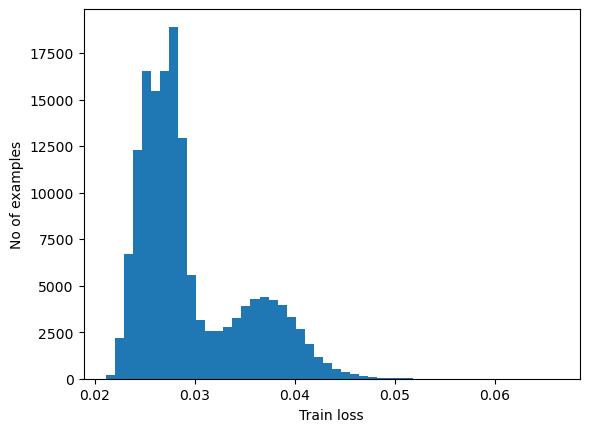

In [28]:
# 閾値の計算
S=0.5
train_anomaly_score = test(best_CVAE, train_dataset)
THRESHOLD = np.mean(train_anomaly_score) + S*np.std(train_anomaly_score)
print("Threshold: ", THRESHOLD)

plt.hist(train_anomaly_score, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

## 評価

AU PR:0.6840651958346529


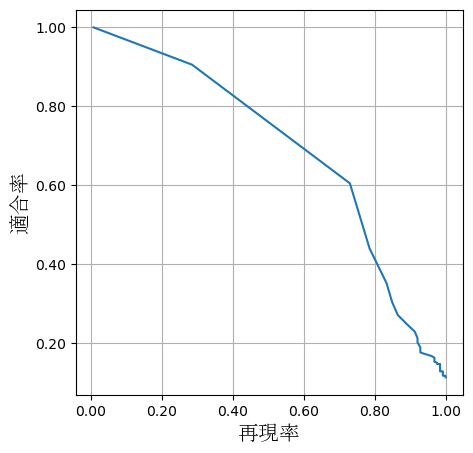

In [29]:
auPR, fig, thr_max_f_score, _ = validate.plot_PR(label_unit, anomaly_score, 100)
fig_PR = validate.plot_to_image(fig)
print(f"AU PR:{auPR}")

AU ROC:0.9727126429914172


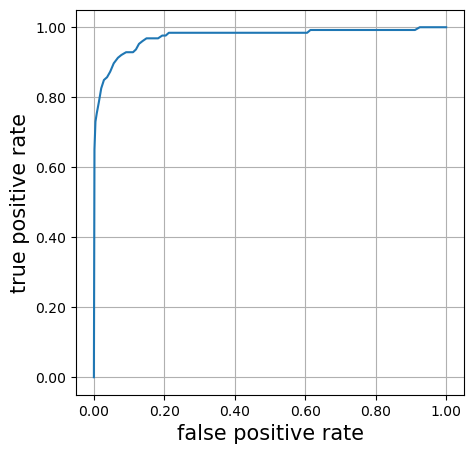

In [30]:
auROC, fig = validate.plot_ROC(label_unit, anomaly_score, 100)
fig_ROC = validate.plot_to_image(fig)
print(f"AU ROC:{auROC}")

In [31]:
####### mlflow ##########
with mlflow.start_run(run_id=MLFLOW_RUN_ID):
    mlflow.log_metric("Threshold", THRESHOLD)
    
    mlflow.log_metric("AU PR", auPR)
    mlflow.log_metric("AU ROC", auROC)

    mlflow.log_image(fig_PR.numpy()[0], 'fig_PR.png')
    mlflow.log_image(fig_ROC.numpy()[0], 'fig_ROC.png')
########################

## 異常度可視化

In [32]:
start='2022-09-21 06:00:00'
end='2022-09-21 22:00:00'

uLimit=anomaly_score.max()

fig = visualization.plot_anomaly_score(start, end, DURATION, anomaly_score, label_unit, thr_max_f_score, uLimit)
fig_anomalyscore = visualization.plot_to_image(fig)

####### mlflow ##########
with mlflow.start_run(run_id=MLFLOW_RUN_ID):
    mlflow.log_image(fig_anomalyscore.numpy()[0], 'fig_anomalyscore.png')
########################

## 異常データの再構成画像可視化

In [33]:
def plot_spectrogram(x):
    fig, axes = plt.subplots(1, figsize=(12, 8))
    axes.imshow(x, origin='lower')
    axes.set_title('Spectrogram')
    
    return fig

npy_output: data_output\npy\abnormal\npy_files


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1019.52it/s]


Wall time: 2.33 s


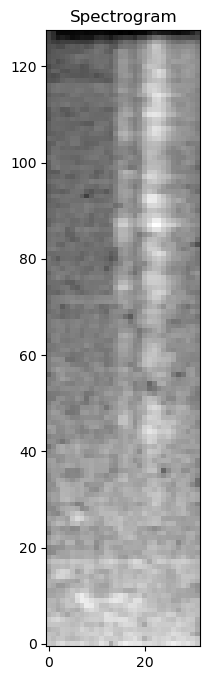

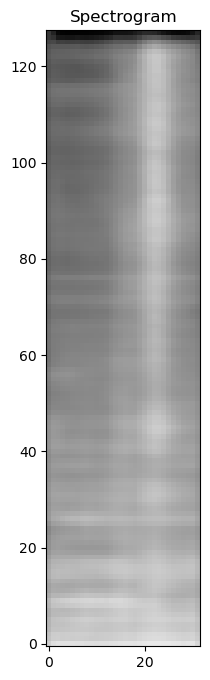

In [34]:
%%time
import tensorflow as tf

abnormal_wav = ["../../data/閾値に使用するデータ/wav_異常音/210922_0033/210922_0033_0;0;11-0;0;13.wav"]
abnormal_npy = "./data_output/npy/abnormal"

_, _ = wav_to_spectrogram(abnormal_npy, abnormal_wav, SR, DURATION, MEL_PAEAMS, overwrite=True)

list_abnormal_npyFiles = glob.glob(f'{abnormal_npy}/npy_files/*')
# データセット
abnormal_dataset = return_dataset_loader(list_abnormal_npyFiles,
                                      IMAGE_SIZE,
                                      training=False, 
                                      mean=train_mean, 
                                      std=train_std, 
                                      batch_size=BATCH_SIZE)

for batch_x in abnormal_dataset.take(1):
    input_image = batch_x[0]
    fig = plot_spectrogram(input_image)
    image_input = visualization.plot_to_image(fig)

    batch_image = tf.expand_dims(input_image,axis=0)
    training=False
    model_x = best_CVAE(batch_image, training=training)
    fig = plot_spectrogram(model_x[0])
    image_output = visualization.plot_to_image(fig)
    
####### mlflow ##########
with mlflow.start_run(run_id=MLFLOW_RUN_ID):
    mlflow.log_image(image_input.numpy()[0], 'image_input.png')
    mlflow.log_image(image_output.numpy()[0], 'image_output.png')
########################